In [3]:
import pandas as pd
import numpy as np
from collections import Counter
%matplotlib inline
import plotly.graph_objects as go
import re
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import TweetTokenizer
import preprocessor as p # if it gives problems, use from preprocessor.api import clean
import plotly.express as px
import glob
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report
from sklearn.linear_model import SGDClassifier
import pickle
import os

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Lorenzo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Lorenzo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
if not os.path.exists("./images"):
    os.mkdir("./images")

df = pd.read_csv('political_tweets.csv', usecols = ['text','party'])


# For deepnote, load splitted files and join them
"""
all_files = glob.glob(os.path.realpath(os.path.join('./dataset' , "*.csv")))
li = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

df = pd.concat(li, axis=0, ignore_index=True)
df.head() """

'\nall_files = glob.glob(os.path.realpath(os.path.join(\'./dataset\' , "*.csv")))\nli = []\n\nfor filename in all_files:\n    df = pd.read_csv(filename, index_col=None, header=0)\n    li.append(df)\n\ndf = pd.concat(li, axis=0, ignore_index=True)\ndf.head() '

In [5]:
# Divide the dataframe in two for the two parties
df_gop = df[df["party"] == "R"]
df_dem = df[df["party"] == "D"]

In [6]:
df.head()

,text,party
0,Sgt. Martland should be commended - not punish...,R
1,Don’t be fooled by the President’s tweets. The...,D
2,As if decriminalizing illegal immigration and ...,R
3,Good luck to @BadgerMBB! #OnWisconsin #MarchMa...,R
4,"6 years ago, the Obama Administration gave #DR...",D


In [7]:
# Clean the data to prepare it for the analysis
def clean_data(dataf, stop_words):
    def preprocess_data(data):
        data = data.astype(str).str.replace('\d+', '')  # Removes Numbers
        lower_text = data.str.lower()
        lemmatizer = nltk.stem.WordNetLemmatizer()
        w_tokenizer = TweetTokenizer()

        def lemmatize_text(text):
            return [(lemmatizer.lemmatize(w)) for w
                    in w_tokenizer.tokenize((text))]

        def remove_punctuation(words):
            new_words = []
            for word in words:
                new_word = re.sub(r'[^\w\s]', '', (word))
                if new_word != '':
                    new_words.append(new_word)
            return new_words

        words = lower_text.apply(lemmatize_text)
        words = words.apply(remove_punctuation)
        return pd.DataFrame(words)

    df_clean = pd.DataFrame()
    df_clean['hashtag'] = dataf['text'].apply(lambda x: re.findall(r"#(\w+)", x))
    df_clean['text'] = dataf['text'].apply(p.clean) # if it gives problems, use clean without the p and edit the import at the beginning
    df_clean['party'] = dataf['party']
    pre_tweets = preprocess_data(df_clean['text'])
    df_clean['text'] = pre_tweets
    df_clean['text'] = df_clean['text'].apply(lambda x: " ".join([item for item in x if item not in stop_words]))
    df_clean['text'].replace("", np.nan, inplace=True)
    df_clean = df_clean.dropna()
    return df_clean


stop_words = set(stopwords.words('english'))
df_gop_clean = clean_data(df_gop, stop_words)
df_gop_clean.index = pd.RangeIndex(len(df_gop_clean.index))
df_dem_clean = clean_data(df_dem, stop_words)
df_dem_clean.index = pd.RangeIndex(len(df_dem_clean.index))

C:\Users\Lorenzo\AppData\Local\Temp/ipykernel_6196/203384658.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  data = data.astype(str).str.replace('\d+', '')  # Removes Numbers
C:\Users\Lorenzo\AppData\Local\Temp/ipykernel_6196/203384658.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  data = data.astype(str).str.replace('\d+', '')  # Removes Numbers


In [8]:
# Get the 30 most frequent words (bigger than 2 letters to avoid useless words)
def extract_main_words(dataf, n_words, bigger_than):
    df_text = dataf['text'].apply(
        lambda x: [i for i in x.split() if len(i) > bigger_than])
    df_text = df_text.apply(lambda x: " ".join(x))
    return pd.DataFrame(Counter(" ".join(df_text).split()).most_common(n_words), columns=['Word', 'Frequency'])


word_frequency_gop = extract_main_words(df_gop_clean, 30, 2)
word_frequency_dem = extract_main_words(df_dem_clean, 30, 2)

In [9]:
print(word_frequency_gop)

         Word  Frequency
0       today     120046
1       great      90796
2    american      90001
3         day      67972
4       thank      65129
5       state      60579
6        bill      60442
7        year      60434
8        time      60282
9     support      59622
10       work      58568
11       need      58425
12  president      56971
13     family      56462
14      house      55126
15       help      55048
16     people      53440
17        new      52974
18        job      48013
19        act      47065
20        one      45483
21   congress      44114
22  community      43958
23        get      43509
24     thanks      42923
25   business      42690
26   democrat      41623
27       week      40176
28    country      38783
29       make      37772


In [10]:
print(word_frequency_dem)

         Word  Frequency
0       today     125718
1    american     114334
2        need     104263
3       trump      92133
4      people      88680
5      family      87258
6   community      81714
7      health      79470
8        must      76376
9         day      75817
10       work      74385
11       help      72941
12       time      72556
13        act      70297
14  president      70132
15       year      68157
16       make      66982
17      right      66121
18        get      66017
19        new      62975
20   congress      62064
21    support      62054
22        one      61529
23       bill      61478
24      thank      61413
25       care      60673
26      house      59567
27       vote      57505
28      state      55786
29    country      54990


In [11]:
print("Words appearing only for Republicans:")
print(pd.concat([word_frequency_dem["Word"], word_frequency_gop["Word"], word_frequency_dem["Word"]]).drop_duplicates(keep=False))
print("Words appearing only for Democrats:")
print(pd.concat([word_frequency_gop["Word"], word_frequency_dem["Word"], word_frequency_gop["Word"]]).drop_duplicates(keep=False))

Words appearing only for Republicans:
1        great
18         job
24      thanks
25    business
26    democrat
27        week
Name: Word, dtype: object
Words appearing only for Democrats:
3      trump
7     health
8       must
17     right
25      care
27      vote
Name: Word, dtype: object


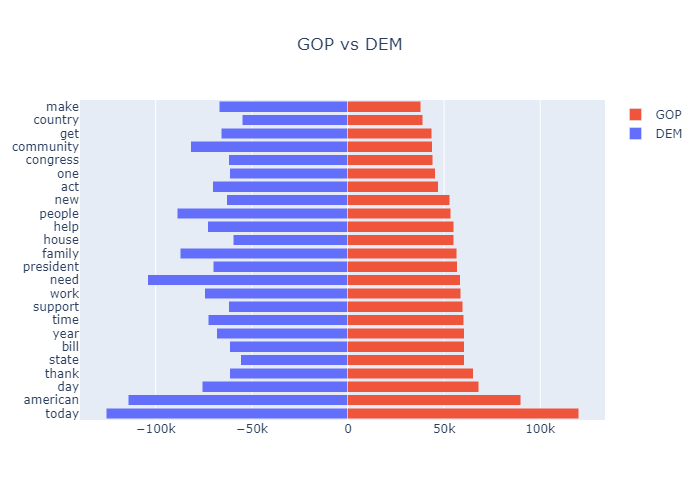

In [12]:
common = pd.merge(word_frequency_gop, word_frequency_dem, how='inner', on=['Word'])

fig = go.Figure(data=[
    go.Bar(y=common['Word'], x=-common["Frequency_y"], orientation='h', name="DEM", base=0),
    go.Bar(y=common['Word'], x=common['Frequency_x'], orientation='h', name="GOP", base=0)
])

fig.update_layout(
    barmode='stack',
    title={'text': f"GOP vs DEM",
          'x':0.5,
          'xanchor': 'center'
    })

fig.update_yaxes(
        ticktext=common['Word'],
        tickvals=common['Word']
    )
fig.show(renderer="png")
fig.write_image("./images/frequent.png")

In [13]:
# Extract the 10 most common hashtags
def extract_main_hashtags(dataf, n_words):
    df_hashes = dataf['hashtag'].apply(
        lambda x: [i for i in x])
    df_hashes = df_hashes.apply(lambda x: " ".join(x))
    return pd.DataFrame(Counter(" ".join(df_hashes).split()).most_common(n_words), columns=['Hashtag', 'Frequency'])


hash_frequency_gop = extract_main_hashtags(df_gop_clean, 10)
hash_frequency_dem = extract_main_hashtags(df_dem_clean, 10)

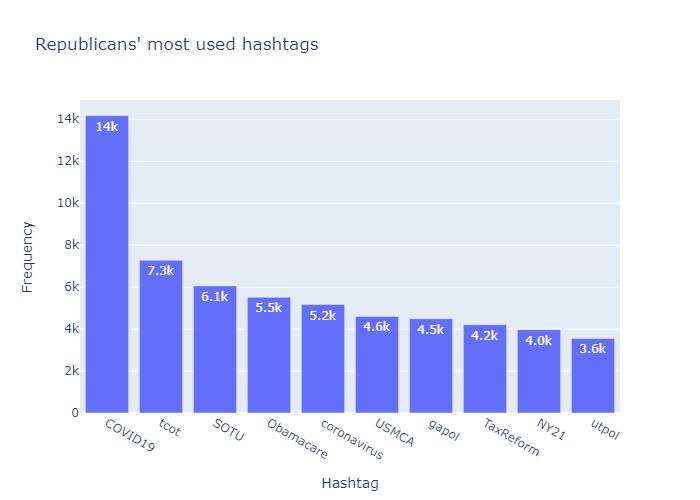

In [14]:
fig = px.bar(hash_frequency_gop, y='Frequency', x='Hashtag', text_auto='.2s',
            title="Republicans' most used hashtags")
fig.show(renderer="png")
fig.write_image("./images/gophash.png")

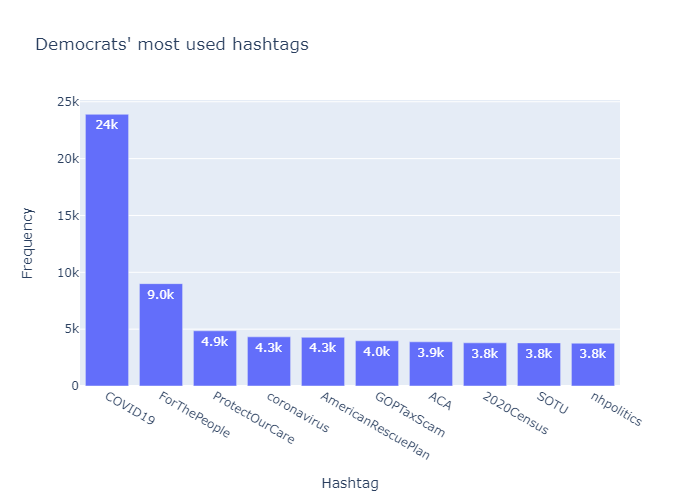

In [15]:
fig = px.bar(hash_frequency_dem, y='Frequency', x='Hashtag', text_auto='.2s',
            title="Democrats' most used hashtags")
fig.show(renderer="png")
fig.write_image("./images/demhash.png")

In [60]:
# Calculate the sentiment for each tweet
def extract_sentiment(dataf, sia):
    df_full = dataf
    sentList = []
    for i in df_full['text']:
        sentList.append((sia.polarity_scores(i))['compound'])

    df_full['sentiment'] = pd.Series(sentList)

    def sentiment_category(sentiment):
        label = ''
        if(sentiment>0):
            label = 'positive'
        elif(sentiment == 0):
            label = 'neutral'
        else:
            label = 'negative'
        return(label)

    df_full['sentiment_category'] = df_full['sentiment'].apply(sentiment_category)
    return df_full

sia = SentimentIntensityAnalyzer()
df_gop_text_full = extract_sentiment(df_gop_clean, sia)
df_dem_text_full = extract_sentiment(df_dem_clean, sia)

In [61]:
df_gop_text_full.head()

,hashtag,text,party,sentiment,sentiment_category
0,[],sgt martland commended punished proud support ...,R,0.6908,positive
1,[],decriminalizing illegal immigration providing ...,R,-0.6486,negative
2,"[OnWisconsin, MarchMadness]",good luck,R,0.7096,positive
3,[standwithjackie],need help apply intern come join u campaign trail,R,0.5994,positive
4,"[S2155, RegRelief]",senate beginning vote today procommunity bank ...,R,0.6908,positive


In [62]:
# Calculate the sentiment for the most common words of each party
common_gop = common.drop(["Frequency_y"], axis=1).rename(columns={"Frequency_x": "Frequency"})
common_gop["Sentiment"] = 0
common_dem = common.drop(["Frequency_x"], axis=1).rename(columns={"Frequency_y": "Frequency"})
common_dem["Sentiment"] = 0

for index, row in common_gop.iterrows():
    w = df_gop_text_full[df_gop_text_full['text'].str.contains(row["Word"])]
    common_gop.loc[index, "Sentiment"] = w["sentiment"].mean()
    w2 = df_dem_text_full[df_dem_text_full['text'].str.contains(common_dem.loc[index, "Word"])]
    common_dem.loc[index, "Sentiment"] = w2["sentiment"].mean()

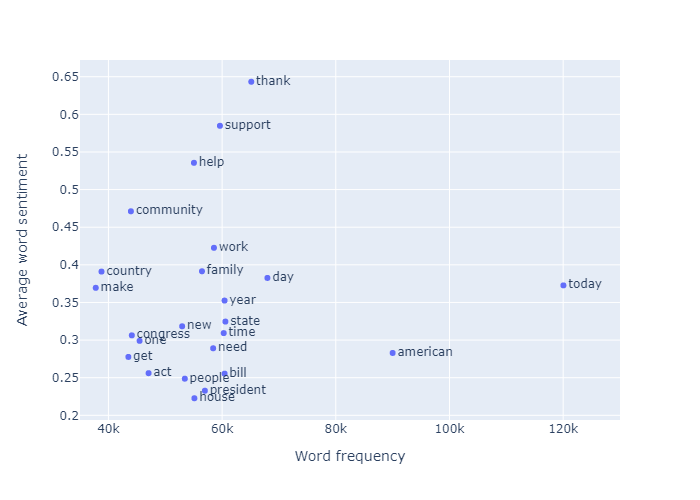

In [63]:
fig = px.scatter(common_gop, x="Frequency", y="Sentiment", text="Word", labels={'Frequency': 'Word frequency', 'Sentiment': 'Average word sentiment'}, range_x=[35000, 130000])
fig.update_traces(textposition="middle right")

fig.show(renderer="png")
fig.write_image("./images/sent_gop.png")

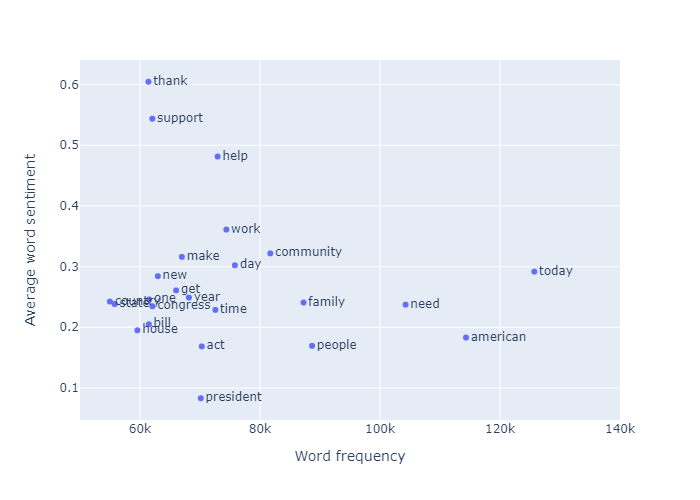

In [64]:
fig = px.scatter(common_dem, x="Frequency", y="Sentiment", text="Word", labels={'Frequency': 'Word frequency', 'Sentiment': 'Average word sentiment'}, range_x=[50000, 140000])
fig.update_traces(textposition="middle right")

fig.show(renderer="png")
fig.write_image("./images/sent_dem.png")

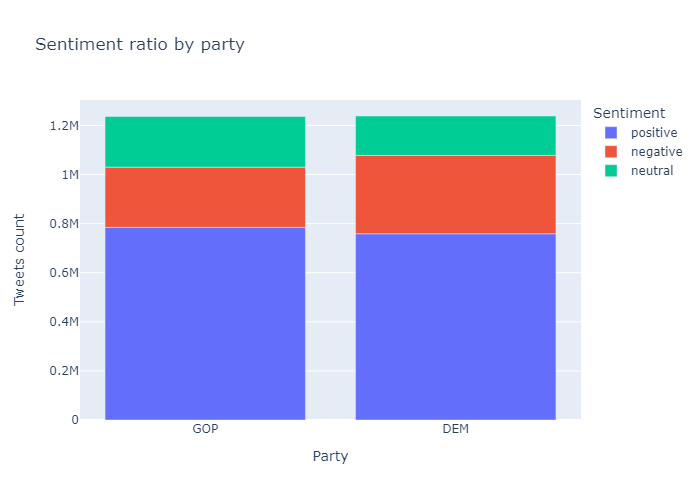

,Party,Count,Sentiment
0,GOP,784385,positive
1,GOP,245417,negative
2,GOP,206267,neutral
3,DEM,758490,positive
4,DEM,319024,negative
5,DEM,160694,neutral


In [65]:
def generate_df_sentiment(dataf, to_append, sent_array, party):
    for sentiment in sent_array:
        s = pd.DataFrame([[party, to_append[to_append["sentiment_category"] ==
                         sentiment].shape[0], sentiment]], columns=["Party", "Count", "Sentiment"])
        dataf = pd.concat([dataf, s], ignore_index=True)
    return dataf


df_out = pd.DataFrame()
df_out = generate_df_sentiment(df_out, df_gop_text_full, [
                               "positive", "negative", "neutral"], "GOP")
df_out = generate_df_sentiment(df_out, df_dem_text_full, [
                               "positive", "negative", "neutral"], "DEM")
fig = px.bar(df_out, x="Party", y="Count", color="Sentiment",
             title="Sentiment ratio by party", labels={'Count': 'Tweets count'})
fig.show(renderer="png")
fig.write_image("./images/sentiment.png")
df_out


In [66]:
# Remove the hashtag column and join back the two dataframes
df_joined_clean = df_dem_text_full.drop(["hashtag"], axis=1)
df_joined_clean = pd.concat([df_joined_clean, df_gop_text_full], ignore_index=True).drop(["hashtag"], axis=1)

In [67]:
# Save the dataframe in case we want to repeat the following classification without repeating the cleaning phase
df_joined_clean.to_csv('cleaned_backup.csv', index=False)

#df_joined_clean = pd.read_csv('cleaned_backup.csv')

In [85]:
# Create train and test splits and cross validate the Naive Bayes classifier
X_train, X_test, Y_train, Y_test = train_test_split(
    df_joined_clean.text, df_joined_clean.party, test_size=0.2, random_state=226506)

nb = Pipeline([('vect', CountVectorizer(lowercase = False)),
               ('tfidf', TfidfTransformer()),
               ('nb', MultinomialNB()),
               ])

tune_grid = {
    'vect__ngram_range': [(1, 1), (1, 2)],
    'nb__alpha': [0.00001, 0.0001, 0.001, 0.1, 1]
}

tuned_nb = GridSearchCV(nb, tune_grid, cv=5, verbose=4)
tuned_nb = tuned_nb.fit(X_train, Y_train)


Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END nb__alpha=1e-05, vect__ngram_range=(1, 1);, score=0.752 total time=  53.2s
[CV 2/5] END nb__alpha=1e-05, vect__ngram_range=(1, 1);, score=0.752 total time=  50.8s
[CV 3/5] END nb__alpha=1e-05, vect__ngram_range=(1, 1);, score=0.753 total time=  45.5s
[CV 4/5] END nb__alpha=1e-05, vect__ngram_range=(1, 1);, score=0.752 total time=  44.3s
[CV 5/5] END nb__alpha=1e-05, vect__ngram_range=(1, 1);, score=0.753 total time=  44.6s
[CV 1/5] END nb__alpha=1e-05, vect__ngram_range=(1, 2);, score=0.778 total time= 2.9min
[CV 2/5] END nb__alpha=1e-05, vect__ngram_range=(1, 2);, score=0.776 total time= 2.5min
[CV 3/5] END nb__alpha=1e-05, vect__ngram_range=(1, 2);, score=0.776 total time= 2.4min
[CV 4/5] END nb__alpha=1e-05, vect__ngram_range=(1, 2);, score=0.776 total time= 2.2min
[CV 5/5] END nb__alpha=1e-05, vect__ngram_range=(1, 2);, score=0.776 total time= 2.2min
[CV 1/5] END nb__alpha=0.0001, vect__ngram_range=(1, 1);, s

In [86]:
# Save the model
with open('mnb.pkl', 'wb') as fid:
    pickle.dump(tuned_nb, fid)
print(tuned_nb.best_estimator_)

Pipeline(steps=[('vect', CountVectorizer(lowercase=False, ngram_range=(1, 2))),
                ('tfidf', TfidfTransformer()),
                ('nb', MultinomialNB(alpha=0.1))])


In [3]:
""" import pickle
with open('mnb.pkl', 'rb') as fid:
    tuned_nb = pickle.load(fid) """

In [87]:
preds_mnb = tuned_nb.predict(X_test)
Y_test_dummy = Y_test
Y_test_dummy[Y_test_dummy == "D"] = 1
Y_test_dummy[Y_test_dummy == "R"] = 0
preds_mnb[preds_mnb == "D"] = 1
preds_mnb[preds_mnb == "R"] = 0

preds_mnb = preds_mnb.astype(int)
Y_test_dummy = Y_test_dummy.astype(int)
print(accuracy_score(Y_test_dummy, preds_mnb))
print(precision_score(Y_test_dummy, preds_mnb))
print(recall_score(Y_test_dummy, preds_mnb))
print(f1_score(Y_test_dummy, preds_mnb))
print(classification_report(Y_test_dummy, preds_mnb))

0.8076410107182695
0.8118400235475919
0.8015572212198636
0.8066658542529855
              precision    recall  f1-score   support

           0       0.80      0.81      0.81    247107
           1       0.81      0.80      0.81    247749

    accuracy                           0.81    494856
   macro avg       0.81      0.81      0.81    494856
weighted avg       0.81      0.81      0.81    494856



In [5]:
# Cross validate the various SGD-trained classifiers
svm = Pipeline([('vect', CountVectorizer(lowercase=False)),
                ('tfidf', TfidfTransformer()),
                ('svm', SGDClassifier(max_iter=2000, early_stopping=True, validation_fraction=0.2, eta0=0.1, random_state=226506)),
                ])

tune_grid = {
    'vect__ngram_range': [(1, 1), (1, 2)],
    'svm__loss': ["log_loss", "modified_huber", "squared_hinge", "perceptron"],
    'svm__learning_rate': ['adaptive', 'optimal'],
    'svm__alpha': [0.00001, 0.0001, 0.001, 0.1, 1],
}
tuned_svm = GridSearchCV(svm, tune_grid, cv=5, verbose=4)
tuned_svm = tuned_svm.fit(X_train, Y_train)

Fitting 5 folds for each of 80 candidates, totalling 400 fits
[CV 1/5] END svm__alpha=1e-05, svm__learning_rate=adaptive, svm__loss=log_loss, vect__ngram_range=(1, 1);, score=0.747 total time=  54.7s
[CV 2/5] END svm__alpha=1e-05, svm__learning_rate=adaptive, svm__loss=log_loss, vect__ngram_range=(1, 1);, score=0.747 total time=  53.5s
[CV 3/5] END svm__alpha=1e-05, svm__learning_rate=adaptive, svm__loss=log_loss, vect__ngram_range=(1, 1);, score=0.747 total time= 1.2min
[CV 4/5] END svm__alpha=1e-05, svm__learning_rate=adaptive, svm__loss=log_loss, vect__ngram_range=(1, 1);, score=0.747 total time=  54.9s
[CV 5/5] END svm__alpha=1e-05, svm__learning_rate=adaptive, svm__loss=log_loss, vect__ngram_range=(1, 1);, score=0.747 total time= 1.0min
[CV 1/5] END svm__alpha=1e-05, svm__learning_rate=adaptive, svm__loss=log_loss, vect__ngram_range=(1, 2);, score=0.751 total time= 2.3min
[CV 2/5] END svm__alpha=1e-05, svm__learning_rate=adaptive, svm__loss=log_loss, vect__ngram_range=(1, 2);, sco

In [6]:
# Save the model
with open('sgd.pkl', 'wb') as fid:
    pickle.dump(tuned_svm, fid)

In [1]:
""" with open('sgd.pkl', 'rb') as fid:
    tuned_svm = pickle.load(fid)"""

" with open('sgd.pkl', 'rb') as fid:\n    tuned_svm = pickle.load(fid)"

In [7]:
print(tuned_svm.best_estimator_)

Pipeline(steps=[('vect', CountVectorizer(lowercase=False, ngram_range=(1, 2))),
                ('tfidf', TfidfTransformer()),
                ('svm',
                 SGDClassifier(alpha=1e-05, early_stopping=True, eta0=0.1,
                               learning_rate='adaptive', loss='squared_hinge',
                               max_iter=2000, random_state=226506,
                               validation_fraction=0.2))])
Pipeline(steps=[('vect', CountVectorizer(lowercase=False, ngram_range=(1, 2))),
                ('tfidf', TfidfTransformer()),
                ('svm',
                 SGDClassifier(alpha=1e-05, early_stopping=True, eta0=0.1,
                               learning_rate='adaptive', loss='squared_hinge',
                               max_iter=2000, random_state=226506,
                               validation_fraction=0.2))])


In [9]:
preds_svm = tuned_svm.predict(X_test)
Y_test_dummy = Y_test
Y_test_dummy[Y_test_dummy == "D"] = 1
Y_test_dummy[Y_test_dummy == "R"] = 0
preds_svm[preds_svm == "D"] = 1
preds_svm[preds_svm == "R"] = 0

preds_svm = preds_svm.astype(int)
Y_test_dummy = Y_test_dummy.astype(int)

print(accuracy_score(Y_test_dummy, preds_svm))
print(precision_score(Y_test_dummy, preds_svm))
print(recall_score(Y_test_dummy, preds_svm))
print(f1_score(Y_test_dummy, preds_svm))

0.7941760717786018
0.7965210570822797
0.7893143120855632
0.7929013092481025
